In [ ]:
!pip install -q scikit-learn==1.2.2 imbalanced-learn==0.11.0 tensorflow==2.13.0 matplotlib seaborn joblib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Edit this to point to your dataset file in Drive:
DRIVE_CSV_PATH = "/content/drive/MyDrive/cowproject2/egg_hatch/egg_hatching.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ========== 3) Imports ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv(DRIVE_CSV_PATH)
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (6534, 7)


,Incubation_Start_Date,Incubation_End_Date,Temperature,Humidity,Egg_Weight,Egg_Turning_Frequency,Hatched
0,02/07/2024,03/01/2024,37.333174,46.306314,76.294851,3,0
1,11/05/2024,11/24/2024,37.560219,55.175502,52.082160,5,0
2,10/18/2023,11/07/2023,37.513480,53.831357,57.059735,3,1
3,04/16/2024,05/08/2024,37.505345,54.603682,59.535962,4,1
4,09/27/2024,10/16/2024,37.527797,53.573152,54.274306,5,1


In [ ]:
print(df.info())
display(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6534 entries, 0 to 6533
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Incubation_Start_Date  6534 non-null   object 
 1   Incubation_End_Date    6534 non-null   object 
 2   Temperature            6534 non-null   float64
 3   Humidity               6534 non-null   float64
 4   Egg_Weight             6534 non-null   float64
 5   Egg_Turning_Frequency  6534 non-null   int64  
 6   Hatched                6534 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 357.5+ KB
None


,Incubation_Start_Date,Incubation_End_Date,Temperature,Humidity,Egg_Weight,Egg_Turning_Frequency,Hatched
count,6534,6534,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000
unique,731,734,NaN,NaN,NaN,NaN,NaN
top,09/10/2023,01/29/2024,NaN,NaN,NaN,NaN,NaN
freq,22,18,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,37.599559,54.979165,58.038108,4.513162,0.206459
std,NaN,NaN,0.298787,3.009135,5.914646,1.120504,0.404794
min,NaN,NaN,36.559992,44.196841,33.090830,3.000000,0.000000
25%,NaN,NaN,37.393550,52.964039,54.079856,4.000000,0.000000
50%,NaN,NaN,37.601194,55.013331,58.124896,5.000000,0.000000
75%,NaN,NaN,37.800192,57.013533,62.056255,6.000000,0.000000


In [ ]:
# - Parse dates (if present)
# - Create incubation_duration (days)
# - Drop or keep original dates (we keep duration)
# - Ensure numeric columns are numeric

def parse_date_safe(s):
    try:
        return pd.to_datetime(s, dayfirst=False)
    except Exception:
        return pd.to_datetime(s, errors='coerce')

if 'Incubation_Start_Date' in df.columns and 'Incubation_End_Date' in df.columns:
    df['Incubation_Start_Date'] = df['Incubation_Start_Date'].apply(parse_date_safe)
    df['Incubation_End_Date']   = df['Incubation_End_Date'].apply(parse_date_safe)
    df['Incubation_Duration'] = (df['Incubation_End_Date'] - df['Incubation_Start_Date']).dt.days
else:
    df['Incubation_Duration'] = np.nan

num_cols = ['Temperature', 'Humidity', 'Egg_Weight', 'Egg_Turning_Frequency', 'Incubation_Duration']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing essential numeric values
essential = ['Temperature','Humidity','Egg_Weight','Egg_Turning_Frequency','Hatched']
for col in essential:
    if col not in df.columns:
        raise ValueError(f"Expected column missing: {col}")

df = df.dropna(subset=essential)
df = df.reset_index(drop=True)
print("After dropping missing essential rows:", df.shape)

After dropping missing essential rows: (6534, 8)


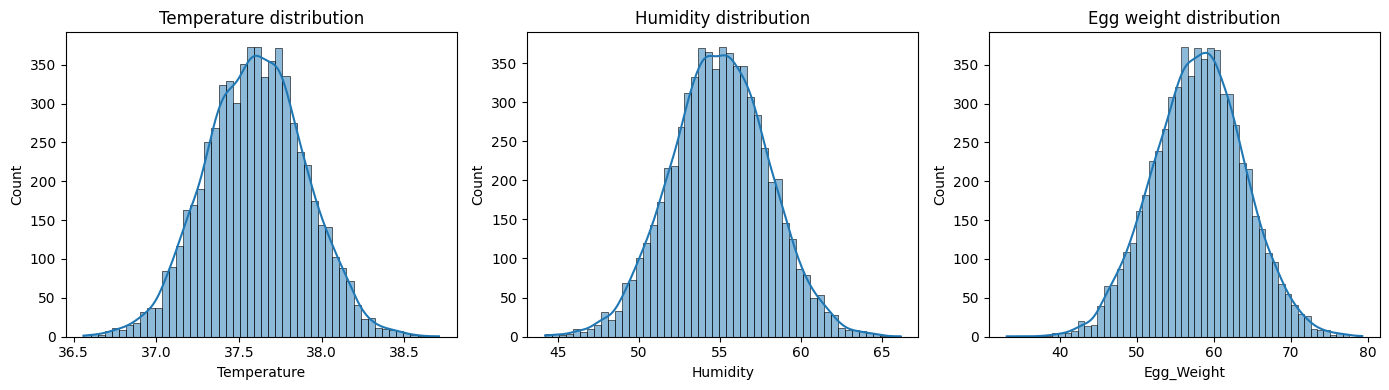

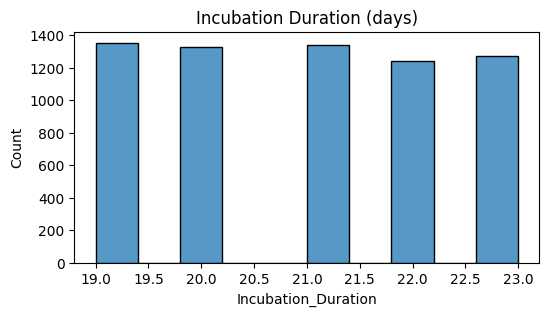

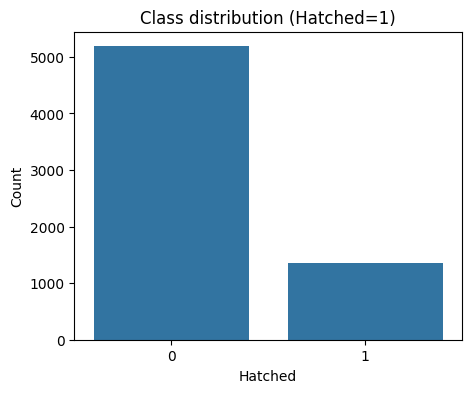

Class counts:
 Hatched
0    5185
1    1349
Name: count, dtype: int64


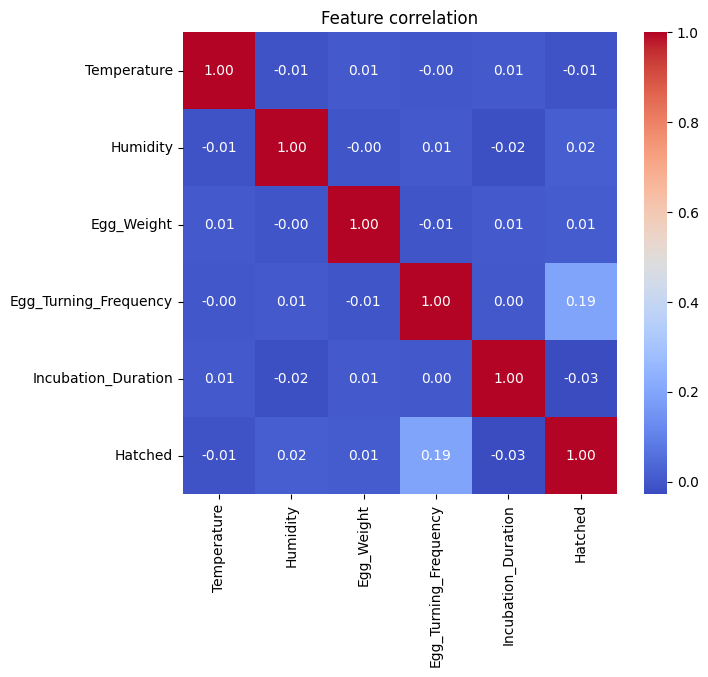

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(df['Temperature'], kde=True)
plt.title('Temperature distribution')

plt.subplot(1,3,2)
sns.histplot(df['Humidity'], kde=True)
plt.title('Humidity distribution')

plt.subplot(1,3,3)
sns.histplot(df['Egg_Weight'], kde=True)
plt.title('Egg weight distribution')
plt.tight_layout()
plt.show()

# Incubation duration distribution (if available)
if df['Incubation_Duration'].notna().sum() > 0:
    plt.figure(figsize=(6,3))
    sns.histplot(df['Incubation_Duration'], bins=10)
    plt.title("Incubation Duration (days)")
    plt.show()

# Class balance
counts = df['Hatched'].value_counts()
plt.figure(figsize=(5,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Class distribution (Hatched=1)")
plt.xlabel("Hatched")
plt.ylabel("Count")
plt.show()
print("Class counts:\n", counts)

# Correlation heatmap
plt.figure(figsize=(7,6))
corr = df[['Temperature','Humidity','Egg_Weight','Egg_Turning_Frequency','Incubation_Duration','Hatched']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature correlation")
plt.show()

In [ ]:
features = ['Temperature','Humidity','Egg_Weight','Egg_Turning_Frequency']
# add incubation duration if available
if df['Incubation_Duration'].notna().sum() > 0:
    features.append('Incubation_Duration')

X = df[features].copy()
y = df['Hatched'].astype(int).copy()

# train/test split with stratify to keep class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print("Train/test sizes:", X_train.shape, X_test.shape)

# ========== 9) Handle imbalance (optional) ==========
print("Before balancing:", y_train.value_counts())
sm = SMOTE(random_state=RANDOM_SEED)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_bal.value_counts())

Train/test sizes: (5227, 5) (1307, 5)
Before balancing: Hatched
0    4148
1    1079
Name: count, dtype: int64
After SMOTE: Hatched
1    4148
0    4148
Name: count, dtype: int64


Random Forest evaluation:
Accuracy: 0.693955623565417
Precision: 0.3153409090909091
Recall: 0.4111111111111111
F1: 0.35691318327974275
ROC AUC: 0.656652023286546
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1037
           1       0.32      0.41      0.36       270

    accuracy                           0.69      1307
   macro avg       0.57      0.59      0.58      1307
weighted avg       0.73      0.69      0.71      1307



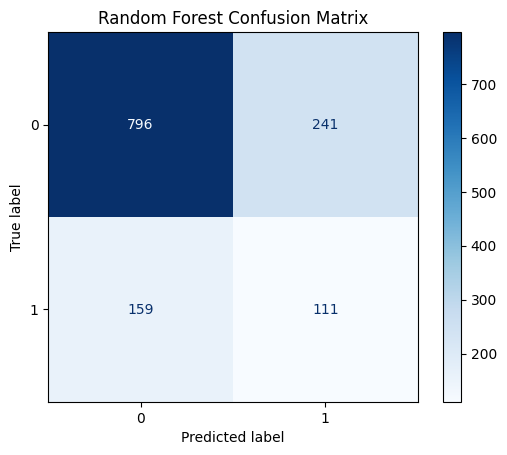

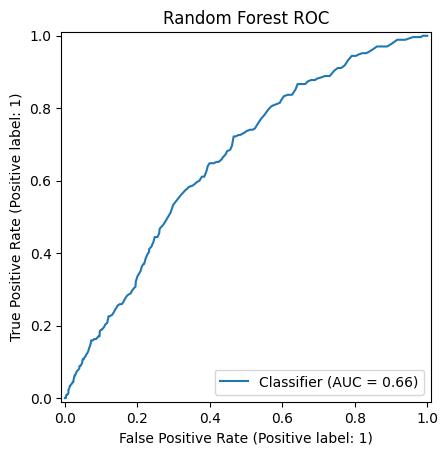

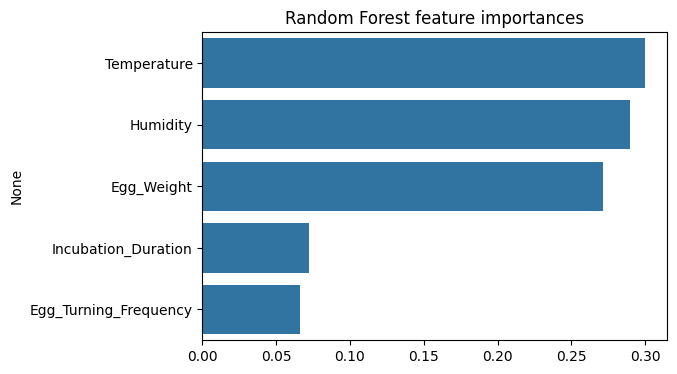

In [ ]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1, class_weight='balanced'
    ))
])

pipe_rf.fit(X_train_bal, y_train_bal)
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

print("Random Forest evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf.named_steps['rf'].classes_)
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest ROC")
plt.show()

# Feature importance
rf_model = pipe_rf.named_steps['rf']
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Random Forest feature importances")
plt.show()


Epoch 1/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5862 - auc: 0.6162 - loss: 0.6613 - val_accuracy: 0.3550 - val_auc: 0.0000e+00 - val_loss: 0.8763
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6511 - auc: 0.7160 - loss: 0.6104 - val_accuracy: 0.4153 - val_auc: 0.0000e+00 - val_loss: 0.8286
Epoch 3/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6700 - auc: 0.7301 - loss: 0.5976 - val_accuracy: 0.4795 - val_auc: 0.0000e+00 - val_loss: 0.7907
Epoch 4/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6855 - auc: 0.7396 - loss: 0.5907 - val_accuracy: 0.5157 - val_auc: 0.0000e+00 - val_loss: 0.7731
Epoch 5/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6856 - auc: 0.7408 - loss: 0.5900 - val_accuracy: 0.5149 - val_auc: 0.0000e+00 - val_loss: 0.7892
Epoch 6/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6930 - auc: 0.7444 - loss: 0.5855 - val_accuracy: 0.5317 - val_auc: 0.0000e+00 - val_loss: 0.7697
Epoch 7/20

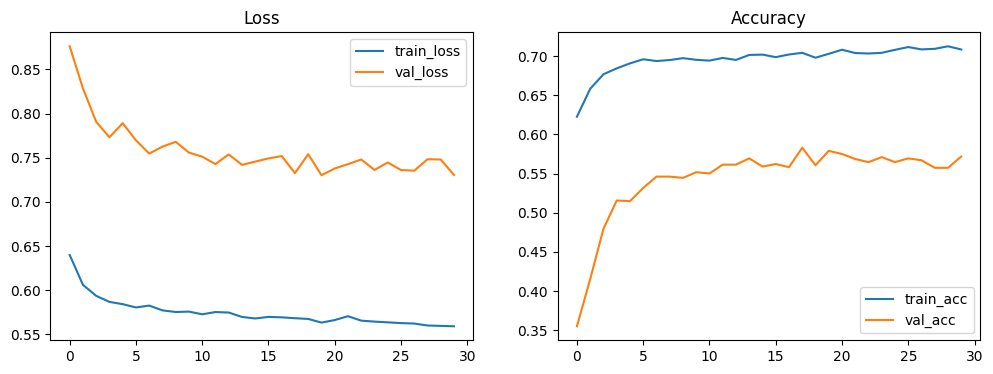

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
NN Evaluation:
Accuracy: 0.7237949502677888
Precision: 0.37110481586402266
Recall: 0.48518518518518516
F1: 0.420545746388443
ROC AUC: 0.6957962784385157


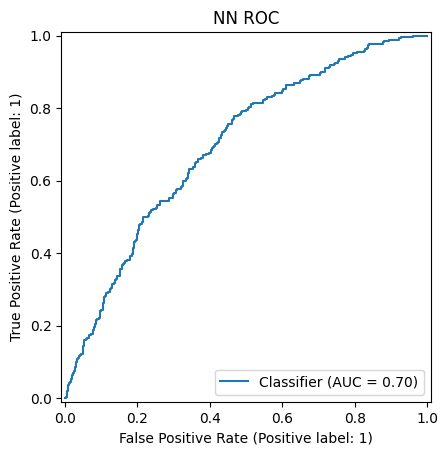

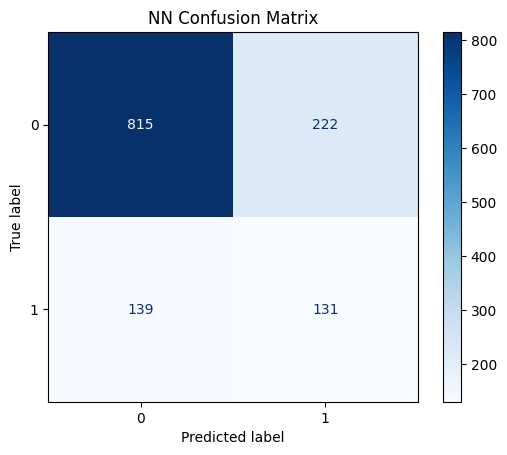

In [ ]:
scaler = StandardScaler().fit(X_train_bal)
X_train_nn = scaler.transform(X_train_bal)
X_test_nn  = scaler.transform(X_test)

# Build model
model = models.Sequential([
    layers.Input(shape=(X_train_nn.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(
    X_train_nn, y_train_bal,
    validation_split=0.15,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], label='train_acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

# Evaluate on test
y_proba_nn = model.predict(X_test_nn).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

print("NN Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F1:", f1_score(y_test, y_pred_nn))
print("ROC AUC:", roc_auc_score(y_test, y_proba_nn))

RocCurveDisplay.from_predictions(y_test, y_proba_nn)
plt.title("NN ROC")
plt.show()

cm_nn = confusion_matrix(y_test, y_pred_nn)
ConfusionMatrixDisplay(cm_nn).plot(cmap='Blues')
plt.title("NN Confusion Matrix")
plt.show()


In [ ]:
RF_SAVE_PATH = "/content/drive/MyDrive/cowproject2/egg_hatch/egg_hatch_rf_pipeline.joblib"
SCALER_SAVE_PATH = "/content/drive/MyDrive/cowproject2/egg_hatch/egg_hatch_scaler.joblib"
NN_SAVE_PATH = "/content/drive/MyDrive/cowproject2/egg_hatch/egg_hatch_nn.h5"

joblib.dump(pipe_rf, RF_SAVE_PATH)
joblib.dump(scaler, SCALER_SAVE_PATH)
model.save(NN_SAVE_PATH)

print("Saved RF pipeline to:", RF_SAVE_PATH)
print("Saved scaler to:", SCALER_SAVE_PATH)
print("Saved NN model to:", NN_SAVE_PATH)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import joblib
import pandas as pd

# Load saved models

RF_MODEL_PATH = "/content/drive/MyDrive/cowproject2/egg_hatch/egg_hatch_rf_pipeline.joblib"
rf_model = joblib.load(RF_MODEL_PATH)

print("Random Forest model loaded.")

# Example: Test on a single new record

# Change these values to your test data
test_data = pd.DataFrame([{
    "Temperature": 37.55,
    "Humidity": 54.8,
    "Egg_Weight": 57.2,
    "Egg_Turning_Frequency": 5,
    "Incubation_Duration": 21  # if your training model included it
}])

# Predict hatch probability
prob = rf_model.predict_proba(test_data)[0][1]
pred = rf_model.predict(test_data)[0]

print("Hatch Probability:", prob)
print("Predicted Class (1 = Hatch, 0 = Not Hatch):", pred)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Random Forest model loaded.
Hatch Probability: 0.78
Predicted Class (1 = Hatch, 0 = Not Hatch): 1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import joblib
import pandas as pd
import numpy as np
import tensorflow as tf

# Load models

SCALER_PATH = "/content/drive/MyDrive/cowproject2/egg_hatch/egg_hatch_scaler.joblib"
NN_MODEL_PATH = "/content/drive/MyDrive/cowproject2/egg_hatch/egg_hatch_nn.h5"

scaler = joblib.load(SCALER_PATH)
nn_model = tf.keras.models.load_model(NN_MODEL_PATH)

print("Neural Network + Scaler loaded.")


# Example test data

test_data = pd.DataFrame([{
    "Temperature": 37.55,
    "Humidity": 54.8,
    "Egg_Weight": 57.2,
    "Egg_Turning_Frequency": 5,
    "Incubation_Duration": 21
}])

# Scale data
scaled = scaler.transform(test_data)

# Predict
prob = nn_model.predict(scaled)[0][0]
pred = 1 if prob >= 0.5 else 0

print("Hatch Probability:", float(prob))
print("Predicted Class:", pred)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Neural Network + Scaler loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Hatch Probability: 0.7112600207328796
Predicted Class: 1
